In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm # for progress bar

Randomization test is adapted from: https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001010

The randomizations work as follows:
1. Create table with one row per mutation that happened in the experiment and a columns per line (genotype-replicate combination). Entry is `True` if the mutation reached the frequency threshold in this line. 
2. Then the table is "randomized":
-  Every row needs to keep the same amount of `True`s (meaning the number of lines a mutation occurs in is kept constant) 
- The number of `True`s per line is kept approximately constant by weighted probabilities: a line that accumulated more mutations will be more likely to be chosen when picking lines for a mutation


In [2]:
# import mutations

fname_mutations_all_samples = 'mutations_of_all_samples_after_filtering.csv'

df = pd.read_csv(fname_mutations_all_samples)

df = df.drop(['Unnamed: 0'], axis=1)
df = df[df['genotype']!='aaa_parental_stock']

df['mutation_id'] = df['Pos'].astype('str')+df['Var']
df['line_id'] = df['genotype']+'_'+df['replicate']

# Prepare data

In [3]:
threshold = 0.1 # majority mutations frequency threshold
n_samples = 1000 #number of randomizations to perform

np.random.seed(111111) #makes results reproducable, seed was randomly generated before first run

In [4]:
# Prepare dataframe 

# filter for majority mutations
# majority = with observed mutation frequency >= threshold
df = df[df['frequency']>=threshold]

df['mutation_id+line_id'] = df['mutation_id'] + df['line_id']

df_pivot = df.pivot_table(values='frequency', 
                          index = 'mutation_id',
                          columns='line_id',
                          aggfunc={'frequency': lambda x : True},
                          fill_value=False 
                         )

df_pivot = df_pivot.reset_index()
df_pivot = df_pivot.set_index('mutation_id')

# Randomization test

In [5]:
def randomize(dataframe):
    '''randomize a dataframe with rows of true/falses, to keep the number of true/falses per row, 
    but change the exact positions'''
    
    # Compute probability of choosing experimental line
    n_mutations_per_line = dataframe.sum()
    weight_of_line = n_mutations_per_line/n_mutations_per_line.sum() 
    
    n_lines_mut_occurs_in = dataframe.sum(1).astype(int)
    
    randomized = [
        np.random.choice(dataframe.columns,p=weight_of_line,size=i,replace=False) 
        for i in n_lines_mut_occurs_in
    ]
    
    return pd.DataFrame(
        [dataframe.columns.isin(i) for i in randomized],columns=dataframe.columns,index=dataframe.index
    )

In [6]:
# list of n_samples random realization of the mutation dataframe
random = [randomize(df_pivot) for i in tqdm(range(n_samples),leave=False, desc='randomizing')]

In [7]:
lines_WT = ['wild_type_replicate_a', 'wild_type_replicate_b', 'wild_type_replicate_c', 'wild_type_replicate_d',
            'wild_type_replicate_e']

lines_OE = ['dicer_overexpressed_replicate_a', 'dicer_overexpressed_replicate_b','dicer_overexpressed_replicate_c',
            'dicer_overexpressed_replicate_d', 'dicer_overexpressed_replicate_e']

lines_KO = ['dicer_ko_replicate_a', 'dicer_ko_replicate_b', 'dicer_ko_replicate_c', 'dicer_ko_replicate_d', 
            'dicer_ko_replicate_e']

# Prepare results for plotting

In [8]:
df_pivot[lines_WT]

line_id,wild_type_replicate_a,wild_type_replicate_b,wild_type_replicate_c,wild_type_replicate_d,wild_type_replicate_e
mutation_id,,,,,
1113C,False,False,False,False,False
1139C,False,False,False,False,False
1252C,False,False,False,False,False
1734C,False,False,False,False,False
2694C,False,False,False,False,False
329G,False,False,False,False,False
3676C,False,False,False,False,False
4570C,True,False,False,False,False
5208C,True,False,False,False,True


In [9]:
# Prepare results for plotting
to_plot = {}

In [10]:
# mutations that are shared only in one GT 

for shared_in_GT, lines_GT in zip(['WT only', 'KO only', 'OE only'], [lines_WT, lines_KO, lines_OE]):

    # select mutations that only occur in one GT
    same = df_pivot[lines_GT].sum(1) == df_pivot.sum(1)
    mut_table_here = df_pivot[same] 
    
    # add observation 
    to_plot[shared_in_GT] = [(mut_table_here.sum(1)>1).sum()]
    
    # add what is expected from the randomization test
    rands = []
    for r in random:
        same = r[lines_GT].sum(1) == r.sum(1)
        mut_table_here = r[same]
        rands.append((mut_table_here.sum(1)>1).sum())
        
    to_plot[shared_in_GT].append(rands)

In [11]:
# mutations that are shared in two genotypes 

# add observations 
set_of_mutations_WT = set(df_pivot[(df_pivot[lines_WT].sum(1)>0)].index)
set_of_mutations_KO = set(df_pivot[(df_pivot[lines_KO].sum(1)>0)].index)
set_of_mutations_OE = set(df_pivot[(df_pivot[lines_OE].sum(1)>0)].index)

shared_mutation_WT_OE = set_of_mutations_WT.intersection(set_of_mutations_OE) - set_of_mutations_KO
shared_mutation_WT_KO = set_of_mutations_WT.intersection(set_of_mutations_KO) - set_of_mutations_OE
shared_mutation_OE_KO = set_of_mutations_OE.intersection(set_of_mutations_KO) - set_of_mutations_WT

to_plot['shared OE and WT'] = [(df_pivot.loc[list(shared_mutation_WT_OE)].sum(1)>1).sum()]
to_plot['shared KO and WT'] = [(df_pivot.loc[list(shared_mutation_WT_KO)].sum(1)>1).sum()]
to_plot['shared OE and KO'] = [(df_pivot.loc[list(shared_mutation_OE_KO)].sum(1)>1).sum()]

# add from randomization tests  

# shared OE and WT
rands = []
for r in random:
    set_of_mutations_WT = set(r[(r[lines_WT].sum(1)>0)].index)
    set_of_mutations_OE = set(r[(r[lines_OE].sum(1)>0)].index)
    set_of_mutations_KO = set(r[(r[lines_KO].sum(1)>0)].index)
    shared_mutation_WT_OE = set_of_mutations_WT.intersection(set_of_mutations_OE) - set_of_mutations_KO
    
    rands.append((r.loc[list(shared_mutation_WT_OE)].sum(1)>1).sum())
to_plot['shared OE and WT'].append(rands)

# shared KO and WT
rands = []
for r in random:
    set_of_mutations_WT = set(r[(r[lines_WT].sum(1)>0)].index)
    set_of_mutations_KO = set(r[(r[lines_KO].sum(1)>0)].index)
    set_of_mutations_OE = set(r[(r[lines_OE].sum(1)>0)].index) 
    shared_mutation_WT_KO = set_of_mutations_WT.intersection(set_of_mutations_KO) - set_of_mutations_OE
    
    rands.append((r.loc[list(shared_mutation_WT_KO)].sum(1)>1).sum())
to_plot['shared KO and WT'].append(rands)

# shared OE and KO
rands = []
for r in random:
    set_of_mutations_WT = set(r[(r[lines_WT].sum(1)>0)].index)
    set_of_mutations_OE = set(r[(r[lines_OE].sum(1)>0)].index)
    set_of_mutations_KO = set(r[(r[lines_KO].sum(1)>0)].index)
    shared_mutation_OE_KO = set_of_mutations_OE.intersection(set_of_mutations_KO) - set_of_mutations_WT
    
    rands.append((r.loc[list(shared_mutation_OE_KO)].sum(1)>1).sum())
to_plot['shared OE and KO'].append(rands)


In [12]:
# mutations that are shared between all three genotypes
# add observations 
set_of_mutations_WT = set(df_pivot[(df_pivot[lines_WT].sum(1)>0)].index)
set_of_mutations_KO = set(df_pivot[(df_pivot[lines_KO].sum(1)>0)].index)
set_of_mutations_OE = set(df_pivot[(df_pivot[lines_OE].sum(1)>0)].index)
shared_mutations_WT_OE_KO = set_of_mutations_WT.intersection(set_of_mutations_OE, set_of_mutations_KO)

# add observations 
to_plot['shared KO, OE and WT'] = [(df_pivot.loc[list(shared_mutations_WT_OE_KO)].sum(1)>=3).sum()]

# add from randomization tests  
rands = []
for r in random:
    set_of_mutations_WT = set(r[(r[lines_WT].sum(1)>0)].index)
    set_of_mutations_KO = set(r[(r[lines_KO].sum(1)>0)].index)
    set_of_mutations_OE = set(r[(r[lines_OE].sum(1)>0)].index)
    shared_mutations_WT_OE_KO = set_of_mutations_WT.intersection(set_of_mutations_OE, set_of_mutations_KO)

    rands.append((r.loc[list(shared_mutations_WT_OE_KO)].sum(1)>1).sum())
to_plot['shared KO, OE and WT'].append(rands)

# Show some statistics on sharing

In [13]:
total = sum([to_plot[i][0] for i in to_plot])
shared = sum([to_plot[i][0] for i in to_plot if 'shared' in i])
print('total number of mutations: ',total)
print('shared mutations: {}, {}%'.format(shared, 100*shared/total) )
print('shared mutations, all genotypes: {}, {}%'.format(to_plot['shared KO, OE and WT'][0],                                                    100*to_plot['shared KO, OE and WT'][0]/total) )

total number of mutations:  15
shared mutations: 14, 93.33333333333333%
shared mutations, all genotypes: 7, 46.666666666666664%


# Plotting

In [14]:
def p_code(p):
    if p<0.001:
        return '***'
    if p< 0.01:
        return '**'
    if p < 0.05:
        return '*'
    if p < 0.1:
        return '.'
    return ''

WT only  :  1
WT only  :  0.387
KO only  :  0
KO only  :  0.376
OE only  :  0
OE only  :  0.366
shared OE and WT  :  4
shared OE and WT  :  2.087
shared KO and WT  :  2
shared KO and WT  :  2.246
shared OE and KO  :  1
shared OE and KO  :  2.096
shared KO, OE and WT  :  7
shared KO, OE and WT  :  7.442


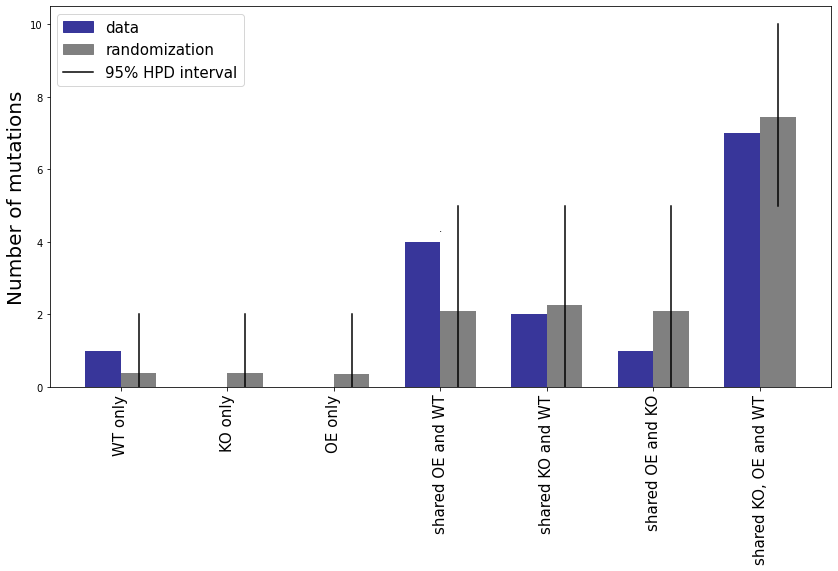

In [19]:
fig = plt.figure(figsize=[14,7])
pos = 0
xpos = []
xlabel = []
for category in to_plot.keys():
        plt.bar(pos,to_plot[category][0],color='#38369A',width=0.5)
        print(category, " : ", to_plot[category][0])
        xpos.append(pos+0.25)
        pos+=0.5
        xlabel.append(category)
        mean = np.mean(to_plot[category][1])
        print(category, " : ", mean)
        plt.bar(pos, mean,color='grey',width=0.5)
        ci = [sorted(to_plot[category][1])[int(n_samples*0.025)],
              sorted(to_plot[category][1])[-int(n_samples*0.025)]]

        plt.plot([pos,pos],ci,color='black')

        p = 1-2*abs((1.0*sum(np.array(to_plot[category][1])>to_plot[category][0])/n_samples)-0.5)

        plt.text(pos-0.25,max(to_plot[category][0],mean)+0.25,p_code(p),
                 va='bottom',ha='center')
        pos+=1

plt.xticks(xpos,xlabel,fontsize=15, rotation=90)
plt.ylabel('Number of mutations',fontsize=20)

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

data = mpatches.Patch(color='#38369A', label='data')
random = mpatches.Patch(color='grey', label='randomization')
hpd = Line2D([0],[0],label='95% HPD interval',color='black')

plt.legend(handles=[data,random,hpd],fontsize=15)
#plt.savefig('fig4_effect_environment.pdf')
plt.show()

Black lines indicate the 95% highest probability density interval of the randomization. 

In [20]:
fig.savefig("./000__Manuscript_figures/Supplement_Figure_5A_host_genotype_adaptation_freqthres0.1.pdf")
fig.savefig("./000__Manuscript_figures/Supplement_Figure_5A_host_genotype_adaptation_freqthres0.1.svg")